In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy import linalg
from scipy.special import digamma,polygamma
from scipy.stats import t
import sys,os


from time import time
np.set_printoptions(precision=22)

#%precision 22
%matplotlib inline

In [2]:
from client import Client
from server import Server

### parameters

In [3]:
data_dir = "testruns/input_files/" # path to data folder
cohorts = ["Split_1","Split_2"]#"Split_3"]
variables = ["Lum","Basal"]
confounders = ["diagnosis_age","stage"]#,"is_LumA"]
normalization_method = "UQ"

path_to_R_limma_files = "testruns/limma_output/" # for testing 

# init_step()

#### server side

In [4]:
server = Server(variables,confounders)
store_clients = {}

#### clinet side 

In [5]:
# client read inputs and join the server
for c in cohorts:
    expression_file_path =data_dir+c+".counts.tsv" # matrix of raw counts 
    annotation_file_path = data_dir+c+".design.tsv" # design matrix
    
    client = Client(c, expression_file_path,annotation_file_path)
    
    store_clients[client.cohort_name] = client
    # join client
    server.join_client(client.cohort_name,client.gene_names,client.n_samples,client.condition_names)

Server: joined client  Split_1
Server: joined client  Split_2


# prepare_inputs()

#### server side

In [6]:
# add cohort columns to the list of confounders on the server side
server.confounders = server.confounders+server.client_names[:-1]    
    
print("Client names:",server.client_names)
print("Samples per client:",server.n_samples_per_cli)
print("Variables:",server.variables)
print("Confounders:",server.confounders)
print("Shared gene names:", len(server.global_genes))
N = np.sum(server.n_samples_per_cli) # total number of samples
print("Samples in total:",N)

Client names: ['Split_1', 'Split_2']
Samples per client: [52, 50]
Variables: ['Lum', 'Basal']
Confounders: ['diagnosis_age', 'stage', 'Split_1']
Shared gene names: 20531
Samples in total: 102


#### clinet side 

In [7]:
# validate inputs:

for c in cohorts:
    client = store_clients[c]
    conditions = server.variables+server.confounders
    # add cohort effect columns to each design matrix
    client.add_cohort_effects_to_design(server.client_names)
    
    client.validate_inputs(server.global_genes,conditions)


1 conditions are excluded from the design matrix: {'is_LumA'}
1 conditions are excluded from the design matrix: {'is_LumA'}


# filterByExprs: Removing lowly expressed genes

* note: requires two rounds of cient-server communication

###  compute_cpm_cutoff_step()
same as filter_parameters_step() in Reza's implementation


In [8]:
# filterByExprs parameters
large_n=10
min_prop=0.7
tol = 1e-14
# user-defined parameters 
min_count=10
min_total_count=15

In [9]:
# server variables - can be defined in previous steps, 
# when the the nuber of shared genes and variables of interest are defined 
# collect number of samples per group, lib.sizes, and total read counts per gene

# how many samples are in every group in the model, e.g. LumA, Basal, etc.
n_samples_in_groups = pd.Series(data=np.zeros(len(server.variables)),index=server.variables)
lib_sizes = []
# total raw read count per genes
total_counts_per_gene = pd.Series(data=np.zeros(len(server.global_genes)),index=server.global_genes)
# count how many samples pass CPM cutoff
n_samples_passing_CPMcutoff = pd.Series(data=np.zeros(len(server.global_genes)),index=server.global_genes)


#### client side

In [10]:
for c in store_clients.keys():
    client = store_clients[c]
    n_samples_in_groups+= client.count_samples_in_groups(server.variables)
    total_counts_per_gene += client.get_total_counts_per_gene()
    lib_sizes.append(client.get_libsizes())


#### server side #### 

In [11]:
lib_sizes  = np.concatenate(lib_sizes)  
print(n_samples_in_groups)
# define min allowed number of samples
min_n_samples = np.min([x for x in n_samples_in_groups if x >0])
if min_n_samples  > large_n:
    min_n_samples = large_n + ( min_n_samples-large_n)*min_prop
print("Min. sample size:",min_n_samples)

Lum      82.0
Basal    20.0
dtype: float64
Min. sample size: 17.0


In [12]:
# find genes passing total count cutoff 
# keep genes if total count is not less than (min_total_count - tol)

keep_total_count = total_counts_per_gene[total_counts_per_gene >= (min_total_count - tol)].index.values
print("Genes passed total count cutoff:",len(keep_total_count))
keep_total_count

Genes passed total count cutoff: 19259


array(['A1BG', 'A1CF', 'A2BP1', ..., 'ZZZ3', 'psiTPTE22', 'tAKR'],
      dtype=object)

In [13]:
# compute CPM cutoff
median_lib_size  = np.median(lib_sizes)
CPM_cutoff = min_count/median_lib_size*1e6
print("median lib.size:",median_lib_size,"\nCPM_cutoff:",CPM_cutoff)



median lib.size: 52309063.0 
CPM_cutoff: 0.19117146105255223


#### client side 

In [14]:
for c in store_clients.keys():
    client = store_clients[c]
    n_samples_passing_CPMcutoff += client.count_samples_passing_CPMcutoff(CPM_cutoff)
    

#### server side 

In [15]:
#keep genes where more than 'min_sample_size' samples passed CPM cutoff
keep_CPM = n_samples_passing_CPMcutoff[n_samples_passing_CPMcutoff>min_n_samples-tol].index.values
print("Genes passed min. sample cutoff:",len(keep_CPM))

Genes passed min. sample cutoff: 16784


In [16]:
# keep genes passed both filters
keep_genes = sorted(list(set(keep_CPM).intersection(set(keep_total_count))))

print("Genes passed filterByExprs",len(keep_genes))

for c in store_clients.keys():
    client = store_clients[c]
    client.apply_filter(keep_genes)

# update global genes at the server side
server.global_genes = keep_genes

Genes passed filterByExprs 16784


# Normalization
* Upperquartile (UQ)
* TMM 

TMM needs an expression profile as a reference;
federated TMM with an averaged expression profile gives different results
=> we implement only UQ

Ignore TMM part

2 rounds of communication

#### client side 
skip TMM part

In [17]:
sum_f = 0

if normalization_method == "UQ":
    print("Upperquartile Normalization...")
    for c in store_clients.keys():
        client = store_clients[c]
        # sum of log(uq/lib.sizes)
        sum_f+= client.compute_sum_log_f()
    
elif normalization_method == "TMM":
    print("TMM Normalization...")
    # compute global average profile to use it as reference 
    avg_profiles = []
    for c in store_clients.keys():
        client = store_clients[c]
        avg_profiles.append(client.get_avg_profile())
    ref = pd.concat(avg_profiles,axis=1).mean(axis=1) # use averaged profile as a reference column
    ref = ref.apply(int)
    
    # compute normalization factors given reference 
    for c in store_clients.keys():
        client = store_clients[c]
        client.compute_TMM_factors(ref)
        f.append(client.unscaled_f)
else:
    print("Normalization method must be 'UQ' or 'TMM'.")

Upperquartile Normalization...


#### server side

In [18]:
F = np.exp(sum_f/N)
print(F)       


5.5358913784876265e-05


#### client side

In [19]:
# compute normalization factors
for c in store_clients.keys():
    client = store_clients[c]
    client.compute_normalization_factors(F)
    

[1.0442055765027    1.0398588632884374 1.046564011248653
 0.9709619244949445 1.0052368290491556 1.00625915888217
 1.0523603148893554 1.06670477495303   0.9983598731735196
 0.8670129882412442 0.9560845207221353 0.9892280837438777
 1.0181692101389122 1.0686082348624861 1.0690931443568574
 0.9696062368439514 1.0321443732162303 0.982807598271319
 1.019238922021251  0.9075441818344056 0.9674847992210698
 0.9688729170065931 0.7945258871598372 1.0002497524162037
 1.0163142808129646 1.0324315854804749 0.9830879423723831
 1.0572788796005803 0.9982460309164353 0.9117366236842177
 0.9828446830956062 1.0505133142190592 1.036273873669172
 1.039557163229232  1.0728920527542014 0.9519437950763688
 1.0859988038037753 0.8653470862167149 1.0928703141801466
 1.0686672161121233 1.1038826515284668 1.0546949510504264
 0.9936237373879806 0.9574860483560407 1.0150601465607458
 1.0869092491548478 1.062666021862062  1.012237543708435
 0.842684300903987  1.079483846887829  0.9912534089226124
 1.0084881127821976]

# Voom

* lmFit *without* weights: fit linear models
* fit LOWESS curve for std-mean trend
* compute weights to compensate the trend
* lmFit *with* weights
* applying contrasts (on the server side => may be joined to the last server step)

6 rounds of communication

In [20]:
# server variables
# for XtX, XtY, beta and stdev
XtX_list = []
XtY_list = []

#### client side 

In [21]:
for c in store_clients.keys():
    client = store_clients[c]

    # logCPM
    client.compute_logCPM()
    
    XtX,XtY = client.compute_XtX_XtY(weighted=False)
    XtX_list.append(XtX)
    XtY_list.append(XtY)


#### server side

In [24]:
server.compute_beta_and_beta_stdev(XtX_list,XtY_list)

In [25]:
### 1) Computes SSE, sigma, and cov. coeficients for clients and aggregates them 
### 2) computes Ameans and log-counts and fits LOWESS
SSE_list = []
cov_coef_list = []
logC_conversion_term = 0
server.Amean = np.zeros(len(server.global_genes))


#### client side

In [26]:
for c in store_clients.keys():
    client = store_clients[c]
    
    # sum of squared residues
    SSE,cov_coef = client.compute_SSE_and_cov_coef(server.beta, weighted = False)
    SSE_list.append(SSE)
    cov_coef_list.append(cov_coef)
    
    # mean log(counts) per gene
    server.Amean += client.logCPM.sum(axis=1)
    logC_conversion_term += np.sum(np.log2(client.lib_sizes+1))

#### server side

In [27]:
server.aggregate_SSE_and_cov_coef(SSE_list,cov_coef_list)
server.compute_mean_logC(logC_conversion_term)
server.fit_LOWESS_curve()


server: delta for LOWESS fit is set to: 0.17215404610075283


#### client side

In [28]:
### 1) converts fitted logCPM to fitted log-counts and
### 2) computes weights 
for c in store_clients.keys():
    client = store_clients[c]
    
    client.calculate_fitted_logcounts(server.beta)
    client.calculate_weights(server.lowess_curve)

#### server side
second linear regression but this time with weights

In [29]:
XtX_list = []
XtY_list = []
SSE_list = []
cov_coef_list = []
logC_conversion_term = 0
server.Amean = np.zeros(len(server.global_genes))

#### client side 

In [30]:
for c in store_clients.keys():
    client = store_clients[c]

    XtX,XtY = client.compute_XtX_XtY(weighted=True)
    XtX_list.append(XtX)
    XtY_list.append(XtY)


#### server side 

In [31]:
server.compute_beta_and_beta_stdev(XtX_list,XtY_list)

#### client side

In [32]:
### 1) Computes SSE, sigma, and cov. coeficients for clients and aggregates them 2) computes Ameans and log-counts and fits LOWE
for c in store_clients.keys():
    client = store_clients[c]
    
    # sum of squared residues
    SSE,cov_coef = client.compute_SSE_and_cov_coef(server.beta, weighted = True)
    SSE_list.append(SSE)
    cov_coef_list.append(cov_coef)
    
    # mean log(counts) per gene
    server.Amean += client.logCPM.sum(axis=1)
    logC_conversion_term += np.sum(np.log2(client.lib_sizes+1))


#### server side 

In [33]:
server.aggregate_SSE_and_cov_coef(SSE_list,cov_coef_list,weighted = True)
server.compute_mean_logC(logC_conversion_term,weighted = True)
server.fit_LOWESS_curve(weighted=True)

server: delta for LOWESS fit is set to: 0.17215404610075283


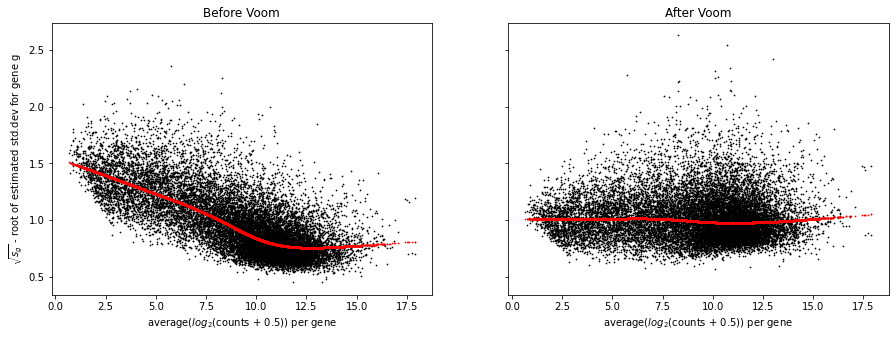

In [34]:
server.plot_voom_results()

In [35]:
client.logCPM.sum(axis=1).values

array([133.9901450255164 ,  98.69707798771945, 461.60866766811193, ...,
       299.5145332398364 , 276.2057589993664 , 109.26819453201124])

In [36]:
# contrasts matrix
contrast_matrix = server.make_contrasts(contrasts=[(["Lum"],["Basal"])])
### applies contrasts
server.fit_contasts(contrast_matrix.values)
contrast_matrix

,Lum_vs_Basal
Lum,1.0
Basal,-1.0
diagnosis_age,0.0
stage,0.0
Split_1,0.0


# eBayes


In [37]:
### all eBayes stepa are on the server side
server.eBayes()

In [38]:
#t = pd.read_csv("flimma/flimma-server/flimma_server/result/ebcb40f2-be40-41a5-a9bf-1c523bc078e3/flimma-result.csv",sep="\t",index_col=0)
#t

In [39]:
# result 
server.table

,t,AveExpr,lods,logFC,CI.L,CI.R,adj.P.Val,P.Value
sample_name,,,,,,,,
FOXA1,31.205896,7.383886,111.557895,6.691418,6.266083,7.116753,1.195193e-49,7.121027e-54
ESR1,24.173768,7.774303,89.310677,7.264928,6.668804,7.861052,5.155742e-40,6.143639e-44
AGR3,20.719940,5.136667,75.875060,9.805651,8.866927,10.744374,1.592475e-34,2.846417e-38
MLPH,20.363690,7.527730,75.224858,5.238801,4.728502,5.749101,4.960097e-34,1.182101e-37
SLC44A4,19.644035,6.039667,72.214129,6.384936,5.740209,7.029662,6.092139e-33,2.198486e-36
...,...,...,...,...,...,...,...,...
KCNQ3,0.000648,-0.246642,-6.578904,0.000277,-0.846533,0.847087,9.997104e-01,9.994841e-01
MAP4K5,0.000588,5.664583,-7.439636,0.000064,-0.216714,0.216843,9.997104e-01,9.995317e-01
GOLPH3,0.000464,7.393656,-7.480392,0.000054,-0.232309,0.232418,9.997501e-01,9.996310e-01


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


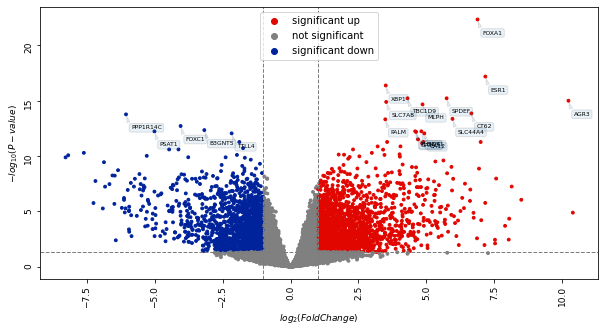

In [56]:
# from: https://reneshbedre.github.io/blog/volcano.html
from bioinfokit import visuz

table = server.table
table["gene_names"] = server.table.index.values
gnames_to_plot = tuple(server.table.head(20).index.values)

visuz.gene_exp.volcano(df=table, lfc='logFC', pv='adj.P.Val',
                       lfc_thr=(1.0,1.0), pv_thr=(0.05,0.05),
                       sign_line=True,
                       genenames=gnames_to_plot ,geneid="gene_names",gstyle=2,gfont=8,
                       plotlegend=True, legendpos='upper center', 
                       figname = "Volcano",figtype="png", 
                       show= True, 
                       color=("#E10600FF", "grey","#00239CFF" ),dim=(10,5))

# Compare p-values and t of limma and fLimma 

In [38]:
# original Limma
limma_table = pd.read_csv(path_to_R_limma_files+"/All.Rlimma_table.tsv",
                          index_col=0,sep = "\t")
limma_table = limma_table.applymap(lambda x: float(x.replace(",",".")))
limma_table 

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
FOXA1,6.735125e+00,6.341204,7.129046,7.365069,3.378397e+01,6.465694e-72,1.088370e-67,152.726055
ESR1,7.171973e+00,6.604122,7.739825,7.821991,2.495618e+01,3.323979e-55,2.797627e-51,115.037317
SPDEF,5.726666e+00,5.216877,6.236455,6.439497,2.219654e+01,3.367632e-49,1.889578e-45,101.400816
MLPH,5.337504e+00,4.831663,5.843345,7.339588,2.084962e+01,4.057534e-46,1.707512e-42,94.424009
CT62,6.413095e+00,5.780444,7.045746,0.182838,2.002984e+01,3.404933e-44,1.146305e-40,88.374073
...,...,...,...,...,...,...,...,...
VDAC2,4.676387e-05,-0.229886,0.229979,6.286632,4.018688e-04,9.996799e-01,9.998796e-01,-7.506913
LOC100134868,1.274070e-04,-0.822525,0.822780,-3.382493,3.060207e-04,9.997562e-01,9.998796e-01,-6.317955
SEC1,-8.350380e-05,-0.549482,0.549315,-2.422942,-3.003257e-04,9.997608e-01,9.998796e-01,-6.401640
ITGAV,4.421225e-05,-0.395222,0.395311,7.446485,2.210174e-04,9.998239e-01,9.998833e-01,-7.521196


In [68]:
server_table  = pd.read_csv("/home/olya/Downloads/9ac7bd75-0135-4e77-931e-9e16be45e484/flimma-result.csv",
                         index_col=0,sep = "\t")
#limma_table = limma_table.applymap(lambda x: float(x.replace(",",".")))
server_table 

,t,AveExpr,lods,logFC,CI.L,CI.R,adj.P.Val,P.Value,gene_names
FOXA1,21.080333,7.368559,50.818935,6.885834,6.230502,7.541166,4.762414e-23,2.853112e-27,FOXA1
ESR1,15.991177,7.729408,39.060687,7.172760,6.272873,8.072647,6.793384e-18,8.139689e-22,ESR1
XBP1,15.177061,10.653686,37.138812,3.506238,3.042753,3.969724,4.350452e-17,7.818930e-21,XBP1
SPDEF,14.111648,6.416305,33.967550,5.747163,4.930096,6.564231,6.278225e-16,1.701209e-19,SPDEF
TBC1D9,14.077757,8.209143,34.025876,4.307376,3.693527,4.921224,6.278225e-16,1.880609e-19,TBC1D9
...,...,...,...,...,...,...,...,...,...
RPS13,0.000735,8.555202,-7.131229,0.000155,-0.423566,0.423876,9.996561e-01,9.994166e-01,RPS13
CD70,0.000234,-2.001508,-6.034924,0.000166,-1.425517,1.425849,9.999552e-01,9.998144e-01,CD70
TELO2,-0.000183,5.011264,-7.043635,-0.000043,-0.474112,0.474026,9.999552e-01,9.998545e-01,TELO2
AGAP6,0.000076,2.354996,-6.565350,0.000022,-0.575287,0.575330,9.999552e-01,9.999398e-01,AGAP6


In [69]:
server.table

,t,AveExpr,lods,logFC,CI.L,CI.R,adj.P.Val,P.Value,gene_names
sample_name,,,,,,,,,
FOXA1,21.080333,7.368559,50.818934,6.885834,6.230502,7.541166,4.762416e-23,2.853113e-27,FOXA1
ESR1,15.991177,7.729408,39.060687,7.172760,6.272873,8.072647,6.793386e-18,8.139691e-22,ESR1
XBP1,15.177061,10.653686,37.138812,3.506238,3.042753,3.969724,4.350452e-17,7.818929e-21,XBP1
SPDEF,14.111648,6.416305,33.967550,5.747163,4.930096,6.564231,6.278227e-16,1.701208e-19,SPDEF
TBC1D9,14.077757,8.209143,34.025876,4.307376,3.693527,4.921224,6.278227e-16,1.880610e-19,TBC1D9
...,...,...,...,...,...,...,...,...,...
RPS13,0.000735,8.555202,-7.131229,0.000155,-0.423566,0.423876,9.996562e-01,9.994166e-01,RPS13
CD70,0.000234,-2.001508,-6.034924,0.000166,-1.425517,1.425849,9.999552e-01,9.998143e-01,CD70
TELO2,-0.000183,5.011264,-7.043635,-0.000043,-0.474112,0.474026,9.999552e-01,9.998545e-01,TELO2


t abs. diff.: max,mean,min: 0.016392084721719158 0.000146488792015966 2.627122963616557e-09
p-value abs. diff.: max,mean,min: 0.0045969080078145375 2.968846838442726e-05 1.1052855664367525e-74


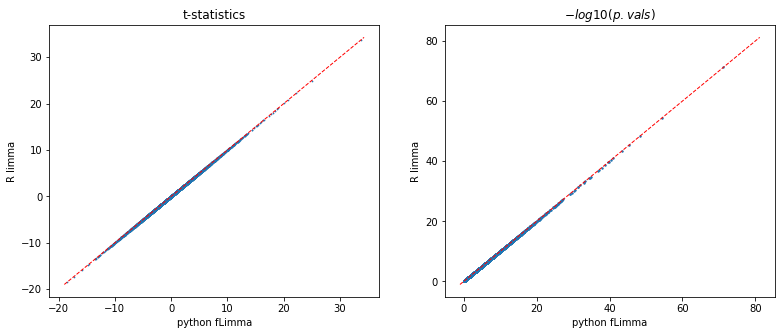

In [41]:
server_table = server.table
result = server.table.loc[limma_table.index.values,:] # result of fLimma arranges in the same order as limma_table

fig, axes = plt.subplots(1, 2, figsize=(13,5), sharey=False)
axes[0].set_title("t-statistics")
axes[0].scatter(x=result["t"], y = limma_table["t"],s=0.5)
xmin = np.min(result["t"])
xmax = np.max(result["t"])
ymin = np.min( limma_table["t"])
ymax = np.max( limma_table["t"])
axes[0].plot([xmin-0.5,xmax+0.5],[xmin-0.5,xmax+0.5],color = "red", linestyle='dashed',linewidth=1)
axes[0].set_xlabel('python fLimma')
axes[0].set_ylabel('R limma')

axes[1].set_title("$-log10(p.vals)$")
axes[1].scatter(x=-np.log10(result["P.Value"]), y = -np.log10(limma_table["P.Value"].values),s=2)
axes[1].set_xlabel('python fLimma')

xmax = max(-np.log10(result["P.Value"]))
ymax = max(-np.log10(limma_table["P.Value"].values))
axes[1].plot([-1,xmax+10],[-1,ymax+10],color = "red", linestyle='dashed',linewidth=1)
tmp = axes[1].set_ylabel('R limma')
diff =  result["t"] - limma_table["t"]
print("t abs. diff.: max,mean,min:", np.max(np.abs(diff)),np.mean(np.abs(diff)),np.min(np.abs(diff)))
diff =  result["P.Value"] - limma_table["P.Value"]
print("p-value abs. diff.: max,mean,min:", np.max(np.abs(diff)),np.mean(np.abs(diff)),np.min(np.abs(diff)))

In [41]:
b = limma_table ["B"]
lods = server.table["lods"]
diff = b - lods
print("B  abs. diff.: max,mean,min:", np.max(np.abs(diff)),np.mean(np.abs(diff)),np.min(np.abs(diff)))

B  abs. diff.: max,mean,min: 0.09100086167586596 0.00038249164459567647 1.8663399853346974e-09
